In [1]:
import os
import sys
import matplotlib
import pandas as pd
import pdb
from IPython import get_ipython
from IPython.display import display


is_notebook = True if "script" not in os.getcwd() else False
recidiviz_data_path = "../../../../../../.." + ("/.." if not is_notebook else "")

sys.path.insert(0, os.path.relpath(recidiviz_data_path))

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import (
    SuperSimulationFactory,
)
from recidiviz.calculator.modeling.population_projection.transition_table import (
    TransitionTable,
)
from recidiviz.calculator.modeling.population_projection.shell_compartment import (
    ShellCompartment,
)
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from functools import partial
import yaml
from recidiviz.utils.yaml_dict import YAMLDict

pd.set_option("display.max_rows", None)

In [2]:
# Get the simulation tag from the model inputs config
yaml_file_path = (
    "../" if not is_notebook else ""
) + "pa_mj_decrim_model_inputs_full_mapping_v3.yaml"

simulation_config = YAMLDict.from_path(yaml_file_path)
data_inputs = simulation_config.pop_dict("data_inputs")
simulation_tag = data_inputs.pop("big_query_simulation_tag", str)

In [3]:
simulation_tag

'pa_mj_decrim_2023_full_mapping_v3'

In [4]:
if (is_notebook):
    get_ipython().run_line_magic('run', recidiviz_data_path + "/../recidiviz-research/utils/research_utils.py")
    adjust_plot_scale(0.4)

# Load simulation

In [5]:
policy_sim = SuperSimulationFactory.build_super_simulation(yaml_file_path)

Downloading: 100%|█████████████████████████████████████████████████████| 204/204 [00:00<00:00, 975.82rows/s]


In [6]:
transitions_post_policy = pd.read_csv(
    ("../" if not is_notebook else "") + "alt_transitions_policy.csv"
)

In [18]:
policy_sim.initializer.data_inputs.transitions_data.groupby(
    ["crime_type", "compartment", "outflow_to"]
).compartment_duration.count()

crime_type  compartment  outflow_to
mj_plus     jail         liberty       14
            liberty      liberty        1
            parole       liberty       25
            prison       liberty       25
                         parole        24
            probation    liberty       23
only_mj     jail         liberty       15
            liberty      liberty        1
            parole       liberty       18
            prison       liberty       17
                         parole        16
            probation    liberty       25
Name: compartment_duration, dtype: int64

In [ ]:
transitions_post_policy[
    (transitions_post_policy.compartment == "prison")
    & (transitions_post_policy.crime_type == "mj_plus")
]

In [19]:
transitions_post_policy.groupby(
    ["crime_type", "compartment", "outflow_to"]
).compartment_duration.count()

crime_type  compartment  outflow_to
mj_plus     jail         liberty       13
            liberty      liberty        1
            parole       liberty       43
            prison       liberty       42
                         parole        38
            probation    liberty       33
only_mj     jail         liberty        1
            liberty      liberty        1
            parole       liberty        1
            prison       liberty        1
            probation    liberty        1
Name: compartment_duration, dtype: int64

In [9]:
## Policy functions
def bypass_system(compartment: str):
    return partial(
        ShellCompartment.reallocate_outflow,
        reallocation_fraction=1,
        outflow=compartment,
        new_outflow="liberty",
    )


def reallocate_prison_to_no_parole():
    return partial(
        TransitionTable.reallocate_outflow,
        reallocation_df=pd.DataFrame(
            {"outflow": "parole", "affected_fraction": 1, "new_outflow": "liberty"},
            index=[0],
        ),
        reallocation_type="*",
        retroactive=True,
    )


def resentence_policy(outflow, policy_impact_percent):
    return partial(
        TransitionTable.apply_reductions,
        reduction_df=pd.DataFrame(
            {
                "outflow": outflow,
                "affected_fraction": 1,
                "reduction_size": policy_impact_percent / 100,
            },
            index=[0],
        ),
        reduction_type="*",
        retroactive=True,
    )


def switch_to_policy_transitions():
    return partial(
        TransitionTable.use_alternate_transitions_data,
        alternate_historical_transitions=transitions_post_policy,
        retroactive=True,
    )

In [10]:
# Simulate policy starting in July 2023
policy_ts = 41

In [11]:
policy_list = (
    ##################################
    # crime_type = mj_plus
    ##################################
    [
        # 1 transition table switch
        SparkPolicy(
            policy_fn=switch_to_policy_transitions(),
            spark_compartment=compartment,
            sub_population={"crime_type": "mj_plus"},
            policy_ts=policy_ts,
            apply_retroactive=True,
        )
        for compartment in ["prison", "jail", "probation", "parole"]
    ]
    ######################################
    # crime_type = only_mj
    ######################################
    + [
        # Reallocate all new admissions from pretrial to liberty
        # pretrial -> [prison, jail, probation]
        # becomes
        # pretrial -> liberty
        SparkPolicy(
            policy_fn=bypass_system(compartment),
            spark_compartment="pretrial",
            sub_population={"crime_type": "only_mj"},
            policy_ts=policy_ts,
            apply_retroactive=True,
        )
        for compartment in ["prison", "jail", "probation"]
    ]
    + [
        # Redirect all prison clients directly to liberty
        # prison -> parole
        # now
        # prison -> liberty
        SparkPolicy(
            policy_fn=reallocate_prison_to_no_parole(),
            spark_compartment="prison",
            sub_population={"crime_type": "only_mj"},
            policy_ts=policy_ts,
            apply_retroactive=True,
        )
    ]
    + [
        # 100% sentence reductions for all only_mj clients
        # * -> liberty immediately
        SparkPolicy(
            policy_fn=resentence_policy("liberty", 100),
            spark_compartment=compartment,
            sub_population={"crime_type": "only_mj"},
            policy_ts=policy_ts,
            apply_retroactive=True,
        )
        for compartment in ["prison", "jail", "probation", "parole"]
    ]
)

/Users/jazz/Recidiviz/pulse-data/recidiviz/calculator/modeling/population_projection/state/PA/mj-decrim/../../../../../../../recidiviz/calculator/modeling/population_projection/population_simulation/population_simulation_factory.py:168: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (simulation_group_name), _ in transitions_data.groupby(disaggregation_axes):


prison
-9999
parole
-9999
jail
-9999
probation
-9999
liberty
-9999
prison
-9999
parole
-9999
jail
-9999
probation
-9999
liberty
-9999
initialization time:  3.720123767852783
prison
-9999
41
parole
-9999
41
jail
-9999
41
probation
-9999
41
liberty
-9999
prison
-9999
41
parole
-9999
41
jail
-9999
41
probation
-9999
41
liberty
-9999


/Users/jazz/Recidiviz/pulse-data/recidiviz/calculator/modeling/population_projection/state/PA/mj-decrim/../../../../../../../recidiviz/calculator/modeling/population_projection/population_simulation/population_simulation_factory.py:168: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (simulation_group_name), _ in transitions_data.groupby(disaggregation_axes):


initialization time:  3.840676784515381
simulation_time:  5.496930122375488
simulation_time:  5.228637218475342
2249.5


/Users/jazz/Recidiviz/pulse-data/recidiviz/calculator/modeling/population_projection/state/PA/mj-decrim/../../../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/simulator.py:314: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  simulation_results = simulation_results.groupby(


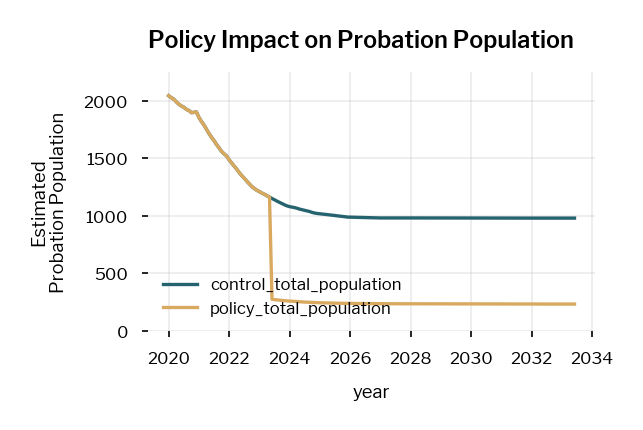

In [12]:
policy_results = policy_sim.simulate_policy(policy_list, "probation")
policy_results["population_difference"] = (
    policy_results["policy_total_population"]
    - policy_results["control_total_population"]
)

In [13]:
simulation_tag

'pa_mj_decrim_2023_full_mapping_v3'

In [14]:
# results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_57132/3066392526.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for compartment, results in policy_results.groupby(["compartment"]):


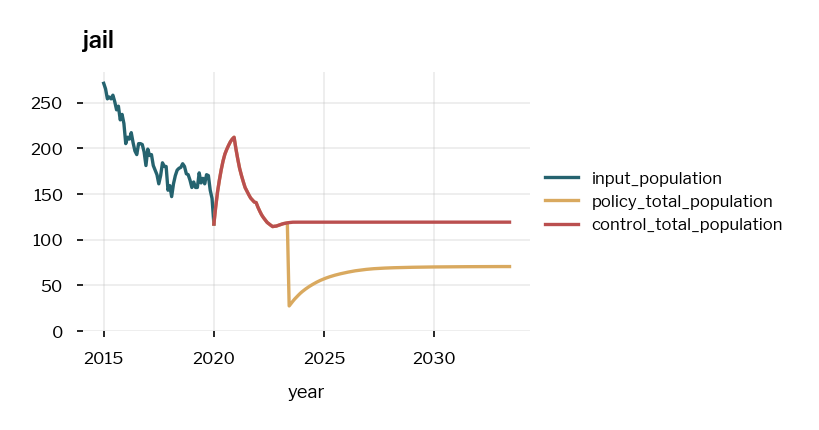

<Figure size 576x336 with 0 Axes>

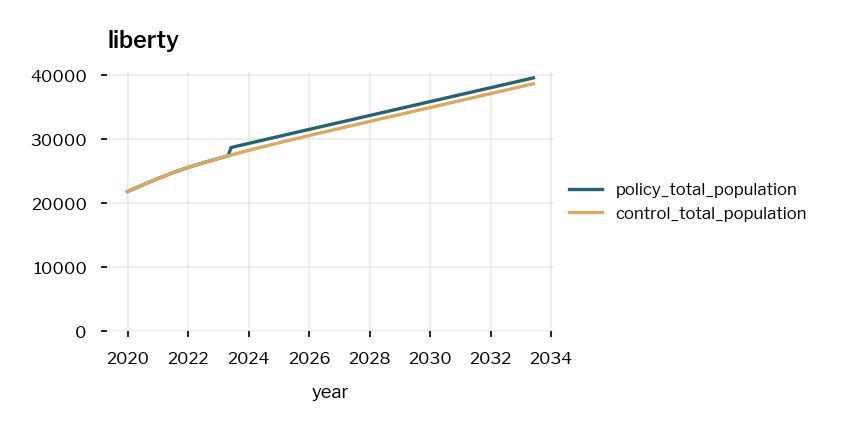

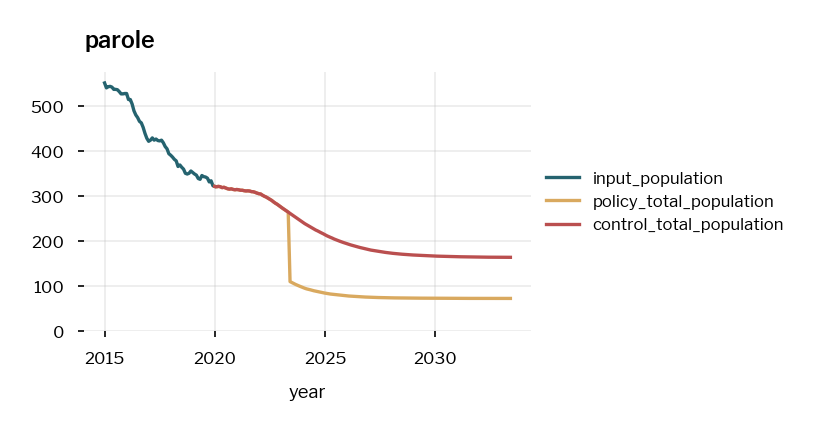

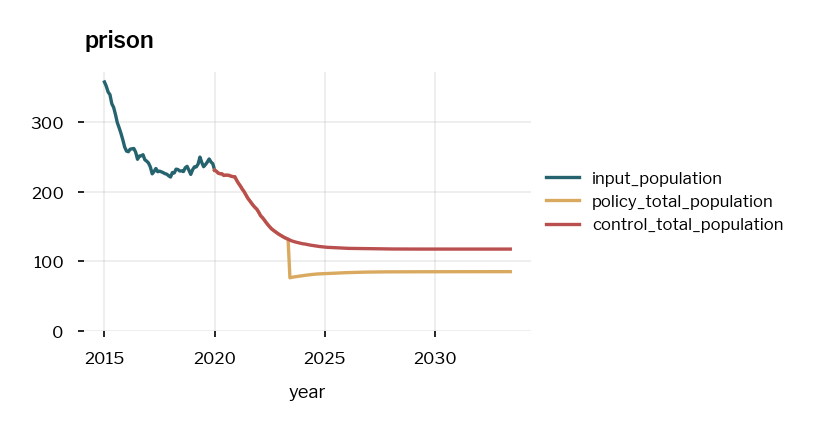

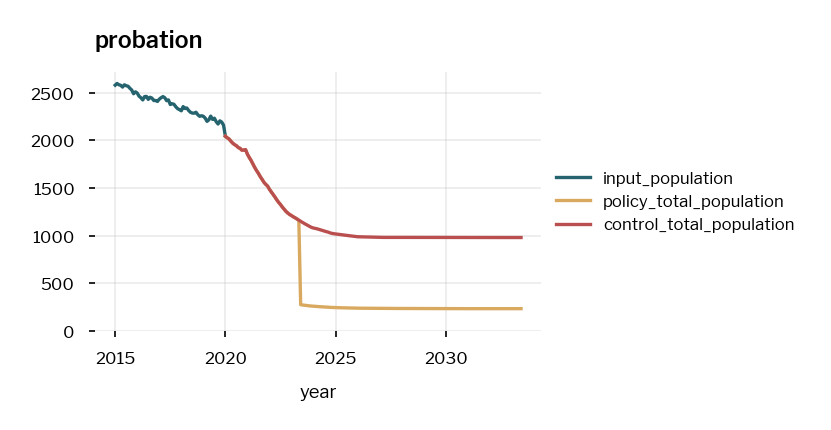

In [15]:
total_population_data = policy_sim.initializer.data_inputs.total_population_data.copy()
total_population_data[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    total_population_data["time_step"]
)
total_population_data = total_population_data.set_index(
    ["crime_type", "compartment", "year"]
).sort_index()["total_population"]

for compartment, results in policy_results.groupby(["compartment"]):
    plt.figure()
    ax = None
    if compartment in total_population_data.index.get_level_values("compartment"):
        ax = (
            total_population_data[
                total_population_data.index.get_level_values("compartment")
                == compartment
            ]
            .groupby("year")
            .sum()
            .plot(label="input_population")
        )
    results.groupby("year")[
        ["policy_total_population", "control_total_population"]
    ].sum().plot(ax=ax)
    add_legend()
    plt.ylim(0)
    plt.title(f"{compartment}")

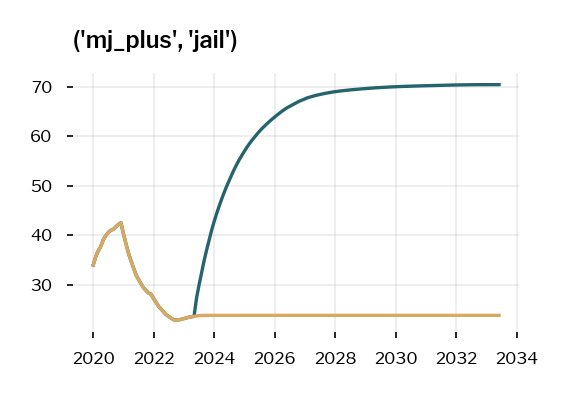

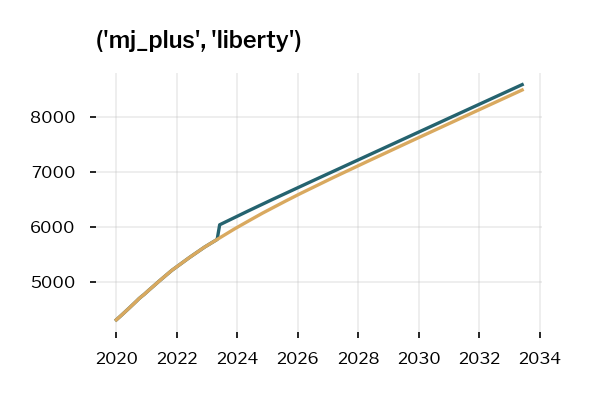

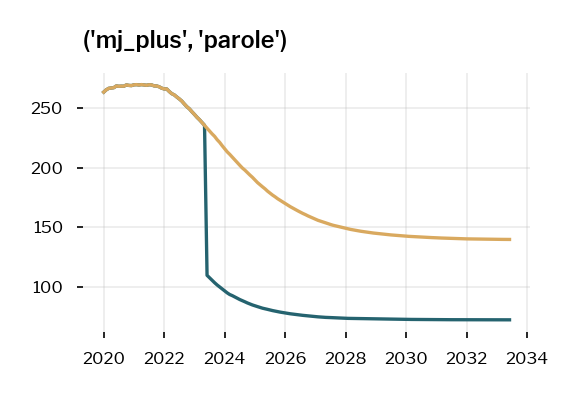

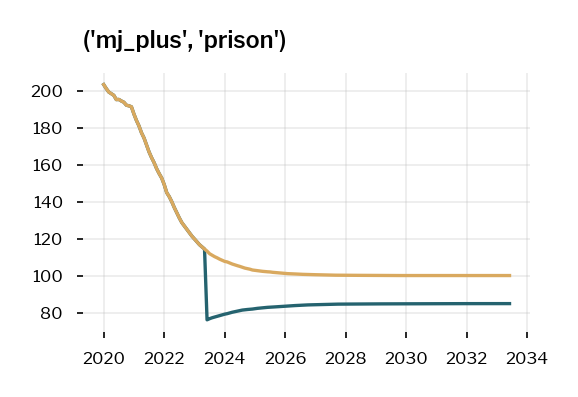

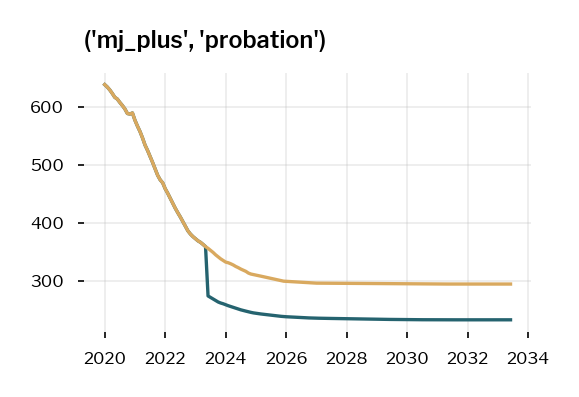

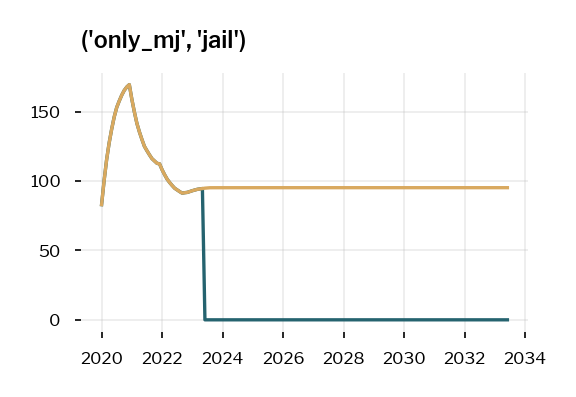

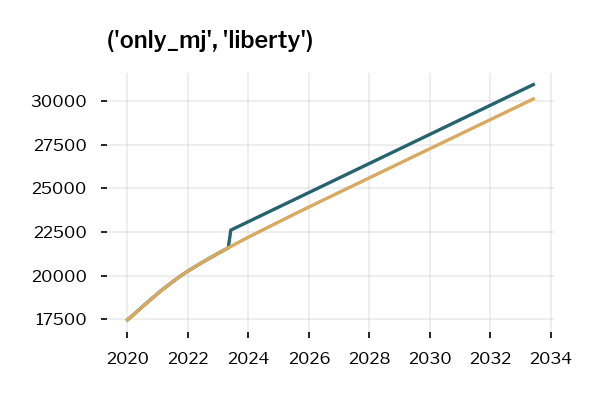

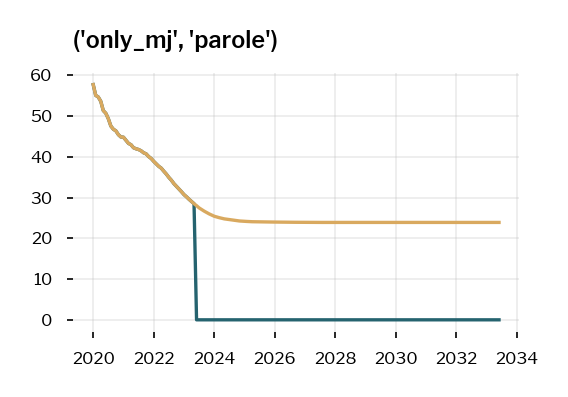

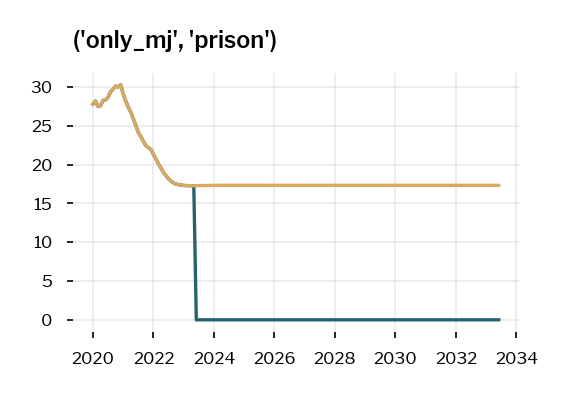

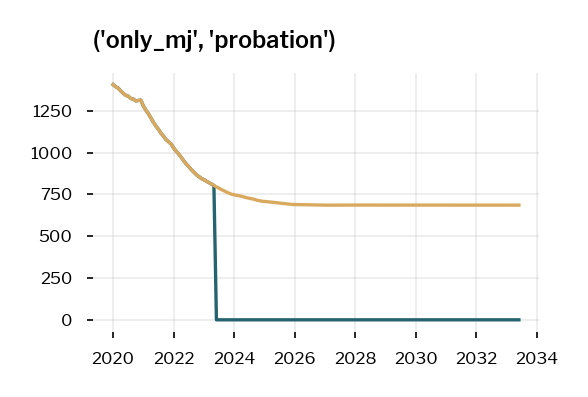

In [16]:
x = 1
for group, results in policy_results.groupby(["simulation_group", "compartment"]):
    plt.figure(x)
    plt.plot(results[["policy_total_population", "control_total_population"]])
    plt.title(f"{group}")
    x += 1
#     policy_results.reset_index().pivot(index='year',columns=['simulation_group','compartment'],values=['policy_total_population','control_total_population']).plot()

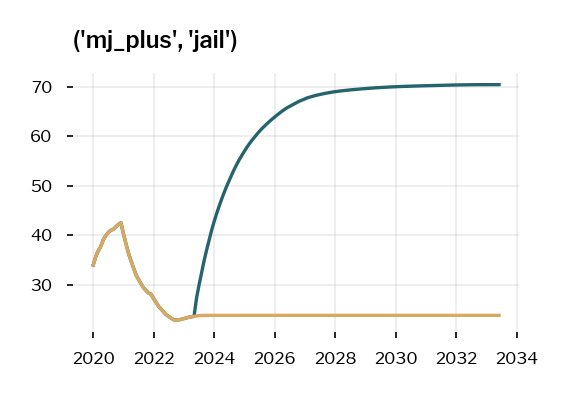

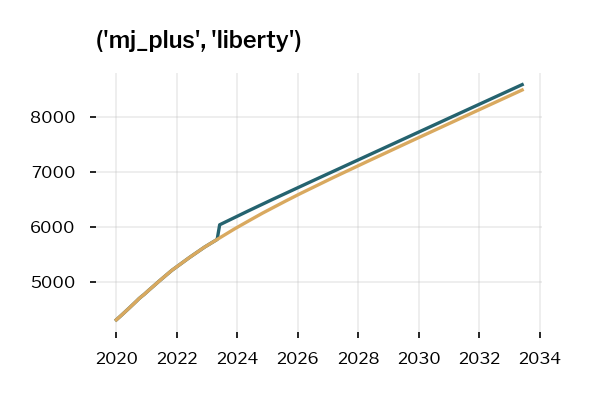

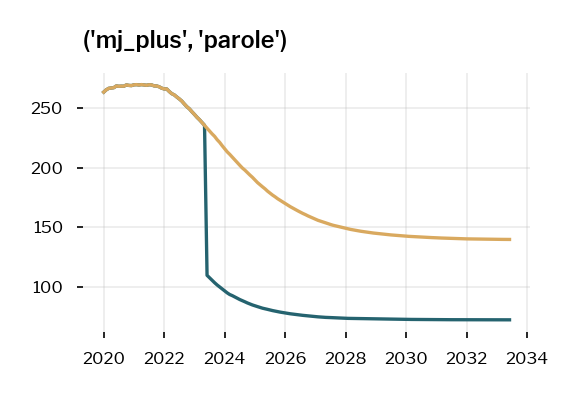

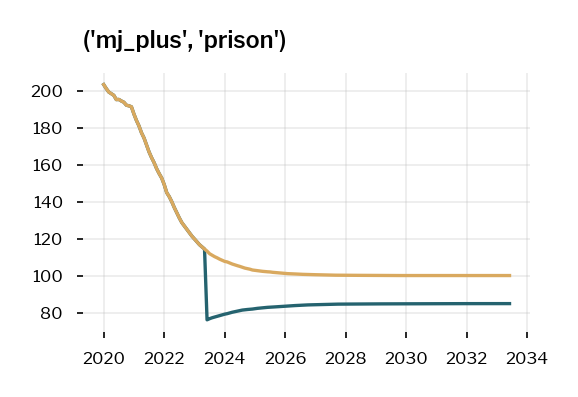

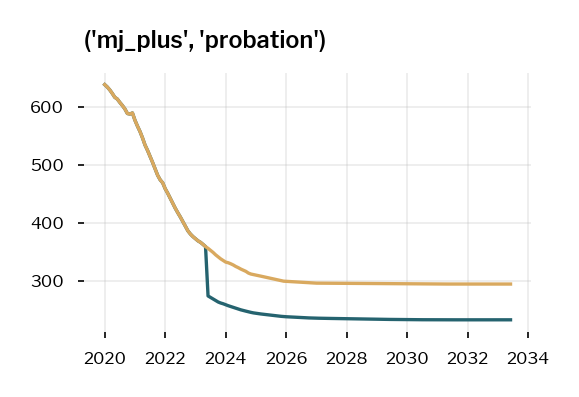

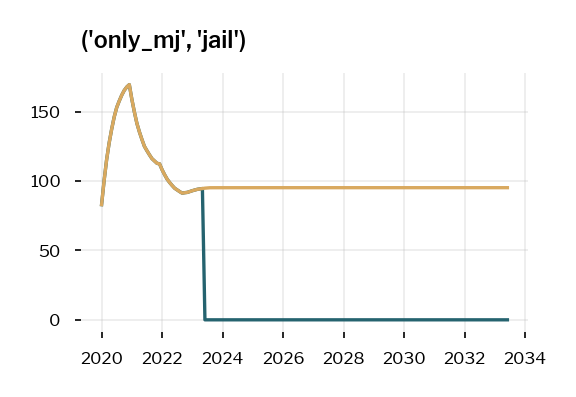

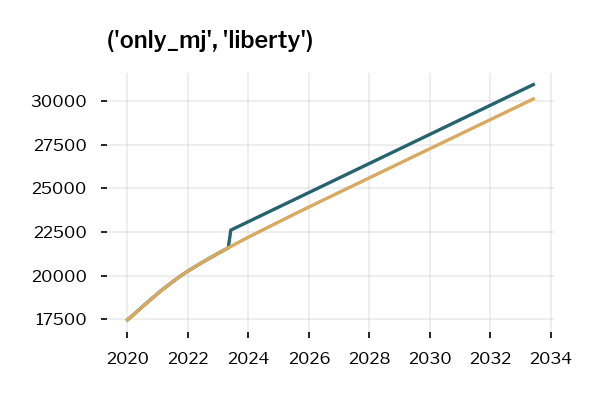

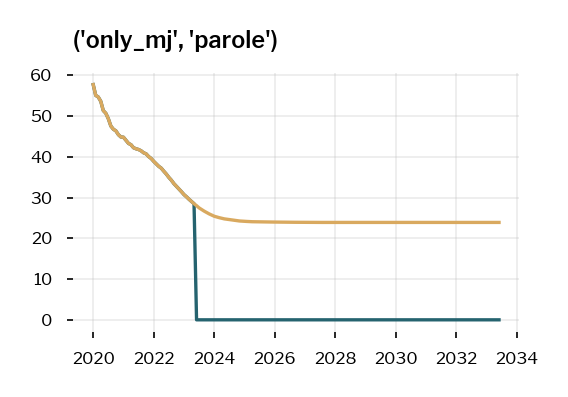

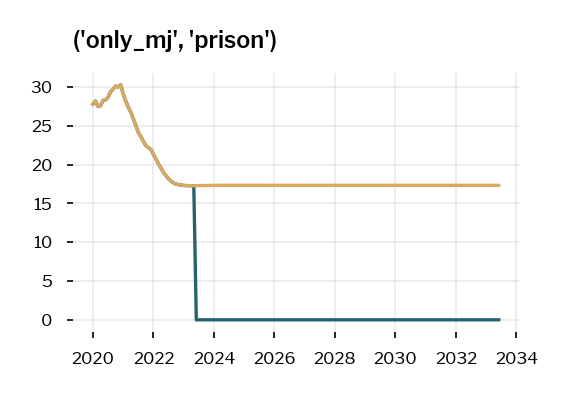

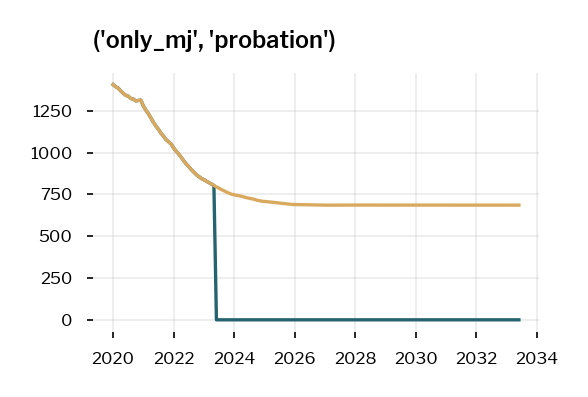

In [17]:
x = 1
for group, results in policy_results.groupby(["simulation_group", "compartment"]):
    #     display(results.head())
    plt.figure(x)
    #     print(group)
    #     display(
    #         pd.concat(
    #             [
    #                 results.sort_values("control_total_population", ascending=False).head(
    #                     1
    #                 ),
    #                 results.sort_values("control_total_population", ascending=False).head(
    #                     1
    #                 ),
    #             ]
    #         )
    #     )
    #     print(f"maxes at ")
    plt.plot(results[["policy_total_population", "control_total_population"]])
    plt.title(f"{group}")
    x += 1
#     policy_results.reset_index().pivot(index='year',columns=['simulation_group','compartment'],values=['policy_total_population','control_total_population']).plot()

In [32]:
policy_results[(policy_results.index > 2022.9) & (policy_results.index <= 2022.99)]

,compartment,control_total_population,simulation_group,policy_total_population,population_difference
year,,,,,
2022.916667,prison,121.357086,mj_plus,121.357086,0.0
2022.916667,parole,247.547960,mj_plus,247.547960,0.0
2022.916667,jail,23.056161,mj_plus,23.056161,0.0
2022.916667,probation,377.044639,mj_plus,377.044639,0.0
2022.916667,liberty,5631.120380,mj_plus,5631.120380,0.0
2022.916667,prison,17.360256,only_mj,17.360256,0.0
2022.916667,parole,31.468258,only_mj,31.468258,0.0
2022.916667,jail,92.430095,only_mj,92.430095,0.0
2022.916667,probation,845.374390,only_mj,845.374390,0.0


In [33]:
policy_results[(policy_results.index > 2023.9) & (policy_results.index <= 2023.99)]

,compartment,control_total_population,simulation_group,policy_total_population,population_difference
year,,,,,
2023.916667,prison,108.227561,mj_plus,62.256365,-45.971196
2023.916667,parole,218.877896,mj_plus,69.907777,-148.970119
2023.916667,jail,23.845709,mj_plus,34.655669,10.809961
2023.916667,probation,335.796589,mj_plus,201.192037,-134.604552
2023.916667,liberty,5966.079617,mj_plus,6284.815805,318.736188
2023.916667,prison,17.320602,only_mj,0.000000,-17.320602
2023.916667,parole,25.725584,only_mj,0.000000,-25.725584
2023.916667,jail,95.178368,only_mj,0.000000,-95.178368
2023.916667,probation,750.849328,only_mj,0.000000,-750.849328


In [34]:
policy_results[
    (policy_results.index > 2022.9) & (policy_results.index <= 2022.99)
].groupby("compartment").sum()

/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_49956/3598819476.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  policy_results[


,control_total_population,policy_total_population,population_difference
compartment,,,
jail,115.486256,115.486256,0.0
liberty,26834.109830,26834.109830,0.0
parole,279.016217,279.016217,0.0
prison,138.717342,138.717342,0.0
probation,1222.419029,1222.419029,0.0


In [35]:
policy_results[(policy_results.compartment == "prison") & (policy_results.index < 2024)]

,compartment,control_total_population,simulation_group,policy_total_population,population_difference
year,,,,,
2020.000000,prison,203.192833,mj_plus,203.192833,0.000000
2020.083333,prison,200.966431,mj_plus,200.966431,0.000000
2020.166667,prison,199.192980,mj_plus,199.192980,0.000000
2020.250000,prison,198.143228,mj_plus,198.143228,0.000000
2020.333333,prison,197.353839,mj_plus,197.353839,0.000000
2020.416667,prison,195.083876,mj_plus,195.083876,0.000000
2020.500000,prison,195.125648,mj_plus,195.125648,0.000000
2020.583333,prison,194.343262,mj_plus,194.343262,0.000000
2020.666667,prison,193.524298,mj_plus,193.524298,0.000000


In [36]:
from IPython.display import display

policy_results[
    (policy_results.index > 2022.9) & (policy_results.index <= 2022.99)
].sort_values(["simulation_group"])

,compartment,control_total_population,simulation_group,policy_total_population,population_difference
year,,,,,
2022.916667,prison,121.357086,mj_plus,121.357086,0.0
2022.916667,parole,247.547960,mj_plus,247.547960,0.0
2022.916667,jail,23.056161,mj_plus,23.056161,0.0
2022.916667,probation,377.044639,mj_plus,377.044639,0.0
2022.916667,liberty,5631.120380,mj_plus,5631.120380,0.0
2022.916667,prison,17.360256,only_mj,17.360256,0.0
2022.916667,parole,31.468258,only_mj,31.468258,0.0
2022.916667,jail,92.430095,only_mj,92.430095,0.0
2022.916667,probation,845.374390,only_mj,845.374390,0.0


In [37]:
policy_results.head()

,compartment,control_total_population,simulation_group,policy_total_population,population_difference
year,,,,,
2020.000000,prison,203.192833,mj_plus,203.192833,0.0
2020.083333,prison,200.966431,mj_plus,200.966431,0.0
2020.166667,prison,199.192980,mj_plus,199.192980,0.0
2020.250000,prison,198.143228,mj_plus,198.143228,0.0
2020.333333,prison,197.353839,mj_plus,197.353839,0.0


In [38]:
policy_sim.initializer.data_inputs.total_population_data.head()

,simulation_tag,time_step,compartment,total_population,crime,crime_type,age,race,date_created
0,pa_mj_decrim_2023_full_mapping_v3,-60,parole,277.838844,None,mj_plus,None,None,2023-03-07 13:07:55.334771+00:00
1,pa_mj_decrim_2023_full_mapping_v3,-60,prison,242.760641,None,mj_plus,None,None,2023-03-07 13:07:55.334771+00:00
2,pa_mj_decrim_2023_full_mapping_v3,-60,probation,660.000000,None,mj_plus,None,None,2023-03-07 13:07:55.334771+00:00
3,pa_mj_decrim_2023_full_mapping_v3,-59,parole,279.512572,None,mj_plus,None,None,2023-03-07 13:07:55.334771+00:00
4,pa_mj_decrim_2023_full_mapping_v3,-59,prison,237.434369,None,mj_plus,None,None,2023-03-07 13:07:55.334771+00:00


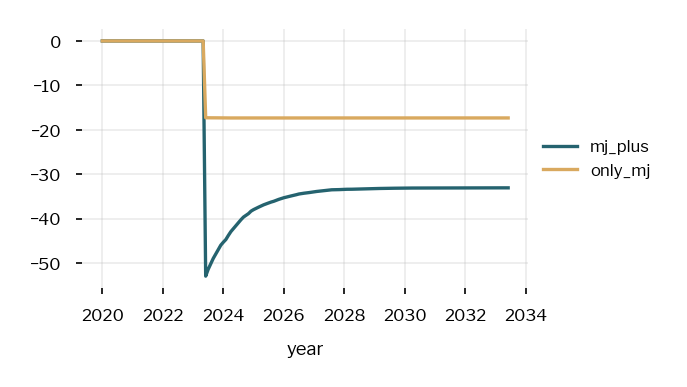

In [39]:
policy_results.groupby(["compartment", "year", "simulation_group"]).sum().loc[
    "prison", "population_difference"
].unstack("simulation_group").plot()
add_legend()

/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_49956/4144902263.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  policy_results.groupby(["compartment", "year"]).sum()["population_difference"].unstack(


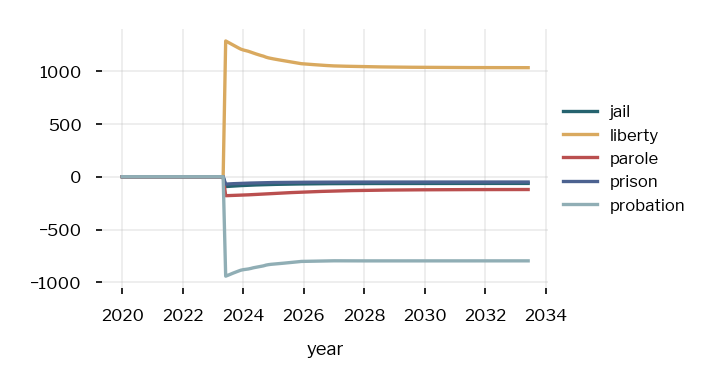

In [40]:
policy_results.groupby(["compartment", "year"]).sum()["population_difference"].unstack(
    "compartment"
).plot()
add_legend()

<AxesSubplot: xlabel='year'>

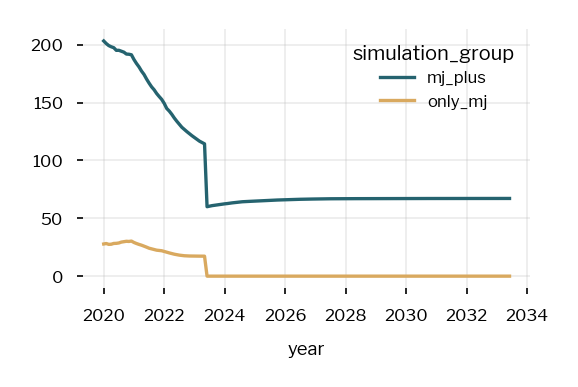

In [41]:
policy_results.groupby(["compartment", "year", "simulation_group"]).sum().loc[
    "prison", "policy_total_population"
].unstack("simulation_group").plot()

In [ ]:
policy_sim.get_arima_output_plots(simulation_title="control", by_simulation_group=True)

In [ ]:
policy_sim.get_arima_output_plots(
    simulation_title="baseline_projections", by_simulation_group=True
)

In [ ]:
policy_sim.simulate_baseline(["prison"])

In [ ]:
baseline_output = policy_sim.validator.pop_simulations["control"].population_projections
baseline_output.set_index(["compartment", "time_step", "simulation_group"]).loc[
    "prison", "total_population"
].unstack("simulation_group").plot()
add_legend()
plt.title("FED HB 5977 Population Projection")

In [ ]:
baseline_outflows = (
    policy_sim.validator.pop_simulations["control"].get_outflows().copy()
)
baseline_outflows[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    baseline_outflows.index.get_level_values("time_step")
)
baseline_outflows = baseline_outflows[baseline_outflows["compartment"] != "release"]
baseline_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()[
    "total_population"
].unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Baseline Simulation Projected Transitions")

In [ ]:
policy_outflows = policy_sim.validator.pop_simulations["policy"].get_outflows().copy()
policy_outflows[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    policy_outflows.index.get_level_values("time_step")
)
policy_outflows = policy_outflows[policy_outflows["compartment"] != "release"]
policy_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()[
    "total_population"
].unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Policy Simulation Projected Transitions")

In [ ]:
policy_outflows[policy_outflows["simulation_group"] == "100"].loc["prison"]

In [ ]:
outflows_diff = baseline_outflows.reset_index(drop=False).merge(
    policy_outflows.reset_index(drop=False),
    how="inner",
    on=["time_step", "outflow_to", "compartment", "simulation_group", "year"],
    suffixes=("_control", "_policy"),
)
outflows_diff["outflows_difference"] = (
    outflows_diff["total_population_policy"] - outflows_diff["total_population_control"]
)
outflows_diff["actual_year"] = np.floor(outflows_diff["year"])
outflows_diff[
    (outflows_diff["compartment"] == "pretrial") & (outflows_diff["year"] >= 2022)
]

In [ ]:
outflows_diff.set_index(["outflow_to", "year", "simulation_group"]).loc[
    "prison", "outflows_difference"
].unstack(["simulation_group"]).plot()

In [ ]:
outflows_diff.head()

In [ ]:
cummulative_outflows_diff = (
    outflows_diff.groupby(["outflow_to", "year"])
    .sum()
    .loc["prison", "outflows_difference"]
    .cumsum()
)
cummulative_outflows_diff.plot()

In [ ]:
cummulative_outflows_diff[
    (cummulative_outflows_diff.index.get_level_values("year") % 1) > 0.9
]

In [ ]:
outflows_diff[outflows_diff["outflow_to"] == "prison"].groupby("actual_year").sum()[
    "outflows_difference"
]

In [ ]:
%%bigquery transitions_df
WITH latest_runs AS
(
SELECT simulation_tag, MAX(date_created) as latest_run
FROM `recidiviz-staging.spark_public_input_data.transitions_data_raw`
GROUP BY simulation_tag
)
SELECT data.*
FROM `recidiviz-staging.spark_public_input_data.transitions_data_raw` data
LEFT JOIN latest_runs ON data.simulation_tag = latest_runs.simulation_tag
WHERE data.simulation_tag = 'fed_h5977'
    AND date_created = latest_runs.latest_run
ORDER BY compartment, compartment_duration

In [ ]:
transitions_df.set_index(["compartment", "crime_type", "compartment_duration"]).loc[
    "prison"
].unstack("crime_type")["total_population"].plot()

In [ ]:
transitions_df.set_index(["compartment", "crime_type", "compartment_duration"]).loc[
    "prison", "5"
]

In [ ]:
%%bigquery population_df
WITH latest_runs AS
(
SELECT simulation_tag, MAX(date_created) as latest_run
FROM `recidiviz-staging.spark_public_input_data.total_population_data_raw`
GROUP BY simulation_tag
)
SELECT data.*
FROM `recidiviz-staging.spark_public_input_data.total_population_data_raw` data
LEFT JOIN latest_runs ON data.simulation_tag = latest_runs.simulation_tag
WHERE data.simulation_tag = 'fed_h5977'
    AND date_created = latest_runs.latest_run
ORDER BY time_step

In [ ]:
population_df[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    population_df["time_step"]
)

In [ ]:
population_df.set_index(["compartment", "year", "crime_type"]).loc["prison"].unstack(
    "crime_type"
)["total_population"].plot()

In [ ]:
for crime_type in ["20", "5"]:
    ax = (
        population_df[population_df["crime_type"] == crime_type]
        .set_index(["compartment", "year"])
        .loc["prison", "total_population"]
        .plot()
    )

    policy_results[policy_results["simulation_group"] == crime_type].groupby(
        ["compartment", "year"]
    ).sum().loc["prison", ["policy_total_population", "control_total_population"]].plot(
        ax=ax
    )
plt.legend().remove()

In [ ]:
policy_results.tail()

# RUN 1 - just prison policies


In [ ]:
policy_results = policy_sim.simulate_policy(policy_list, "prison")
policy_results["population_difference"] = (
    policy_results["policy_total_population"]
    - policy_results["control_total_population"]
)

In [ ]:
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

In [ ]:
policy_results.groupby(["compartment", "year", "simulation_group"]).sum().loc[
    "prison", "population_difference"
].unstack("simulation_group").plot()
add_legend()

In [ ]:
policy_results[policy_results.index >= 2020].groupby(
    ["compartment", "year", "simulation_group"]
).sum().loc["prison", "policy_total_population"].unstack("simulation_group").plot()

## OTHERS

In [ ]:
transition_dict = (
    policy_sim.validator.pop_simulations["policy"]
    .sub_simulations["20"]
    .simulation_compartments["prison"]
    .compartment_transitions.transition_tables
)

policy_ts = min(transition_dfs.keys())
for ts, transition_table in transition_dict[policy_ts].tables.items():
    #     if (policy_key != 15) & (transition_type == TransitionTableType.BEFORE):
    #         continue
    transition_table.plot()
    plt.title(f"{ts} Prison Transition Table")
    add_legend(title="Outflow To")

In [ ]:
transition_dict = (
    policy_sim.validator.pop_simulations["policy"]
    .sub_simulations["5"]
    .simulation_compartments["prison"]
    .compartment_transitions.transition_tables
)

policy_key = max(transition_dict.keys())
for ts, transition_table in transition_dict[policy_key].tables.items():
    transition_table.plot()
    plt.title(f"{ts} Prison Transition Table")
    add_legend(title="Outflow To")